# Imports Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Loading Datasets

In [2]:
# LOading datasets train and test

train_df = pd.read_csv("../demand-forecasting-kernels-only/train.csv")
test_df = pd.read_csv("../demand-forecasting-kernels-only/test.csv", index_col= 0)

In [3]:
print(train_df.shape)
train_df.head()

(913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
print(test_df.shape)
test_df.head()

(45000, 3)


,date,store,item
id,,,
0,2018-01-01,1,1
1,2018-01-02,1,1
2,2018-01-03,1,1
3,2018-01-04,1,1
4,2018-01-05,1,1


In [5]:
print("===========Training dataset dtypes=================")
print(train_df.dtypes)
print("\n===========Testing dataset dtypes==================")
print(test_df.dtypes)

===========Training dataset dtypes=================
date     object
store     int64
item      int64
sales     int64
dtype: object

===========Testing dataset dtypes==================
date     object
store     int64
item      int64
dtype: object


In [6]:
# changing dtypes of date and sales

train_df = train_df.astype({"date":"datetime64[ns]", "sales": "float64", "store": "category", "item": "category"})
test_df = test_df.astype({"date":"datetime64[ns]", "store": "category", "item": "category"})

In [7]:
print("===========Training dataset dtypes=================")
print(train_df.dtypes)
print("\n===========Testing dataset dtypes==================")
print(test_df.dtypes)

===========Training dataset dtypes=================
date     datetime64[ns]
store          category
item           category
sales           float64
dtype: object

===========Testing dataset dtypes==================
date     datetime64[ns]
store          category
item           category
dtype: object


# Statistics

### Total Sales for Each Year

In [8]:
total_sales_df = train_df.drop(columns = ["store", "item"]).set_index("date")

year_month = total_sales_df.index.to_period("M")

total_sales_df = total_sales_df.groupby(year_month).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})
print(total_sales_df.shape)
total_sales_df.head()

(60, 7)


sales                                                   
         count       sum       mean median        std  min    max
date                                                             
2013-01  15500  454904.0  29.348645   27.0  15.087507  2.0   97.0
2013-02  14000  459417.0  32.815500   30.0  16.824119  2.0  103.0
2013-03  15500  617382.0  39.831097   37.0  20.167826  3.0  122.0
2013-04  15000  682274.0  45.484933   42.0  22.898429  3.0  138.0
2013-05  15500  763242.0  49.241419   46.0  24.630070  3.0  156.0

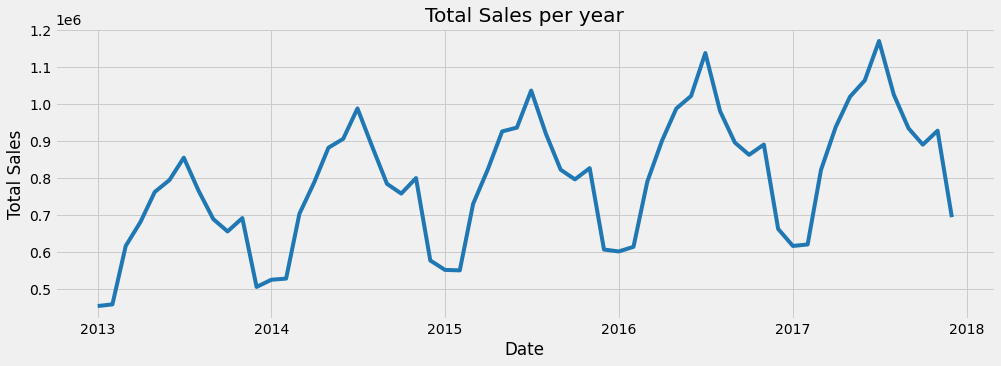

In [9]:
plt.figure(figsize=(15,5))

ax = sns.lineplot(data= total_sales_df,x=total_sales_df.index.astype("datetime64[ns]"),y=('sales','sum'),color= color_pal[0])
ax.set(xlabel='Date', ylabel='Total Sales', title='Total Sales per year')
plt.show()

### Total Sales for Each Store

In [10]:
store_df = train_df.groupby(["store"], as_index=False).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})
store_df = store_df.sort_values([("sales", "sum")], ascending= False).reset_index(drop= True)
print(store_df.shape)
store_df.head()

(10, 8)


store  sales                                                    
         count        sum       mean median        std  min    max
0     2  91300  6120128.0  67.033165   62.0  33.595810  3.0  231.0
1     8  91300  5856169.0  64.142048   60.0  32.231751  4.0  204.0
2     3  91300  5435144.0  59.530602   55.0  29.974102  3.0  196.0
3    10  91300  5360158.0  58.709288   54.0  29.554994  3.0  187.0
4     9  91300  5025976.0  55.049025   51.0  27.832186  4.0  195.0

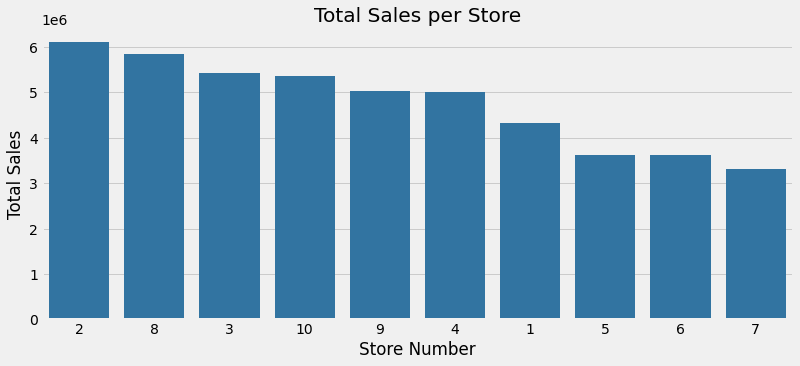

In [11]:
plt.figure(figsize=(12,5))
ax = sns.barplot(data= store_df,x='store',y=('sales','sum'),color= color_pal[0],order= store_df.store)
ax.set(xlabel='Store Number', ylabel='Total Sales', title='Total Sales per Store')
plt.show()

### Total Sales for Each Item

In [12]:
item_df = train_df.groupby(["item"], as_index=False).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})
item_df = item_df.sort_values([("sales", "sum")], ascending= False).reset_index(drop= True)
print(item_df.shape)
item_df.head()

(50, 8)


item  sales                                                     
        count        sum       mean median        std   min    max
0   15  18260  1607442.0  88.030778   85.0  29.522852  17.0  231.0
1   28  18260  1604713.0  87.881325   85.0  29.501781  16.0  206.0
2   13  18260  1539621.0  84.316594   81.0  28.311031  20.0  210.0
3   18  18260  1538876.0  84.275794   81.0  28.430621  18.0  208.0
4   25  18260  1473334.0  80.686418   78.0  27.238817  18.0  193.0

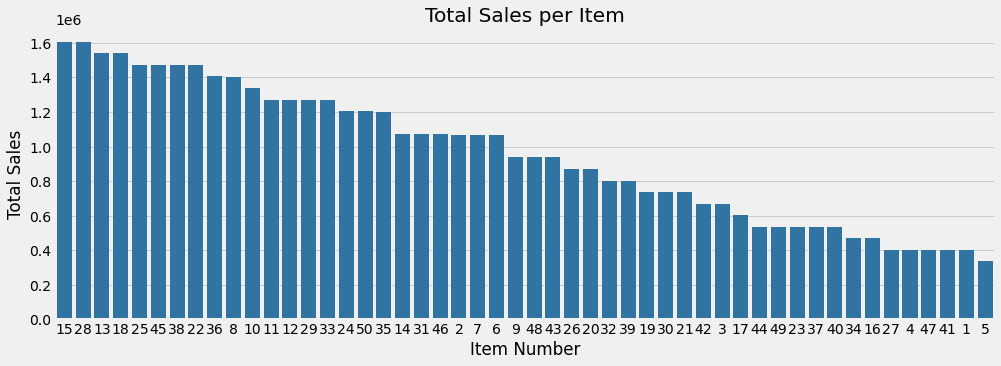

In [13]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data=item_df,x='item',y=('sales','sum'),color= color_pal[0],order=item_df.item)
ax.set(xlabel='Item Number', ylabel='Total Sales', title='Total Sales per Item')
plt.show()

# Training and validation split

In [14]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits= 5, test_size= 6, gap= -1)

training_df = train_df.set_index("date")
year_month = training_df.index.to_period("M")
training_df = training_df.groupby(year_month).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})
training_df = training_df.sort_index()

print(training_df.shape)
training_df.head()

(60, 7)


sales                                                   
         count       sum       mean median        std  min    max
date                                                             
2013-01  15500  454904.0  29.348645   27.0  15.087507  2.0   97.0
2013-02  14000  459417.0  32.815500   30.0  16.824119  2.0  103.0
2013-03  15500  617382.0  39.831097   37.0  20.167826  3.0  122.0
2013-04  15000  682274.0  45.484933   42.0  22.898429  3.0  138.0
2013-05  15500  763242.0  49.241419   46.0  24.630070  3.0  156.0

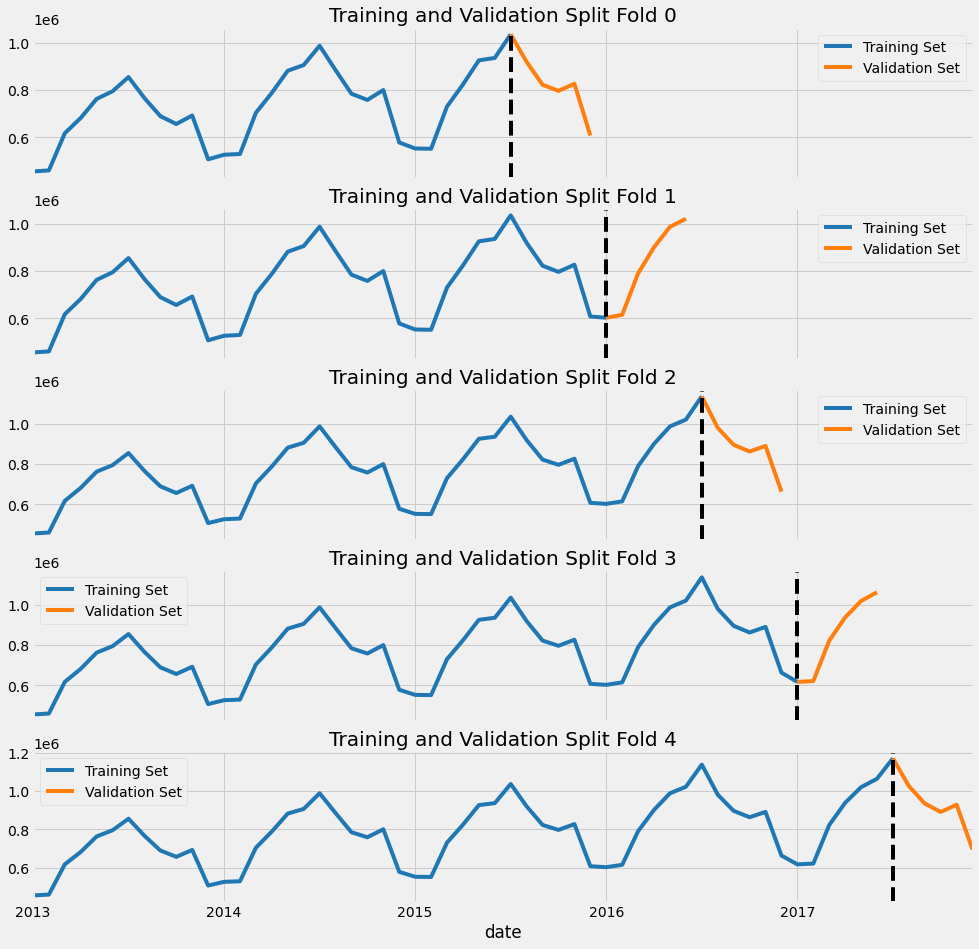

In [15]:
fig, axes = plt.subplots(5, 1, figsize= (15, 15),
                              sharex= True)

for index, (train_id, val_id) in enumerate(tss.split(training_df)):
    train = training_df.iloc[train_id]
    val = training_df.iloc[val_id]
    train[("sales","sum")].plot(ax= axes[index],
                        label= "Training Set",
                        title= f"Training and Validation Split Fold {index}",
                        color= color_pal[0],)
    val[("sales","sum")].plot(ax= axes[index],
                        label= "Validation Set",
                        color= color_pal[1])
    axes[index].axvline(val.index.min(), color= "black", ls= "--")
    axes[index].legend(["Training Set","Validation Set",])

plt.show()